# Our "big" Network

Here we will train a "big&powerful" network which we can then use for our task of classifying fashion items.

This is a bit of an academic example as both the MNIST digits and Fashion MNIST datasets are not that difficult to solve well without transfer learning. However this means we can create a small example that trains in a few minutes instead of having to wait a few days to train something on the ImageNet dataset.

## The plan

* train a network with two convolutional layers on the MNIST digits dataset
* use the convolutions learned by this network as feature extractor on the Fashion MNIST dataset
* train a simple logistic regression model using the extracted features as input.

Remember in this setup we pretend to have only 300 examples from the Fashion MNIST dataset.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [2]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras import utils

Using TensorFlow backend.


## Load MNIST digits dataset

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [4]:
# Add an extra dimension to represent the "colour channels"
X_train = X_train.reshape(X_train.shape[0], 28, 28, -1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, -1)
X_train.shape

(60000, 28, 28, 1)

In [5]:
num_classes = 10
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

## Define big model

In [6]:
# number of filters
filters = 32
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3

input_shape = (28, 28, 1)

batch_size = 128
epochs = 5

# feel free to experiment with how exactly this is setup
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]

# create complete model
mnist_model = Sequential(feature_layers + classification_layers)

In [7]:
mnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
__________

*Note:* this model has about half a million parameters, estimating them from just 300 examples in the Fashion MNIST dataset is hopeless. (If you have time, try it out).

---

In [8]:
mnist_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [9]:
mnist_model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 125s 2ms/step - loss: 0.2461 - acc: 0.9228 - val_loss: 0.0517 - val_acc: 0.9828
Epoch 2/5
60000/60000 [==============================] - 131s 2ms/step - loss: 0.0856 - acc: 0.9741 - val_loss: 0.0452 - val_acc: 0.9854
Epoch 3/5
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0628 - acc: 0.9807 - val_loss: 0.0431 - val_acc: 0.9870
Epoch 4/5
60000/60000 [==============================] - 120s 2ms/step - loss: 0.0555 - acc: 0.9831 - val_loss: 0.0279 - val_acc: 0.9918
Epoch 5/5
60000/60000 [==============================] - 126s 2ms/step - loss: 0.0457 - acc: 0.9860 - val_loss: 0.0297 - val_acc: 0.9910


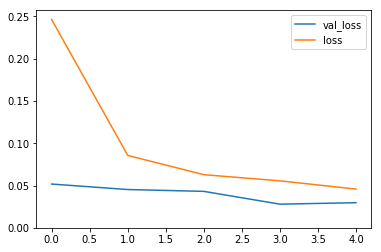

In [10]:
history = _9
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.ylim([0, None])
plt.legend()

## Load Fashion MNIST dataset

Now the transfer learning starts. We will use the flattened output of the "big" neural network trained on MNIST digits as input features for our fashion MNIST task.

In [11]:
from keras.datasets import fashion_mnist


(X_train_f, y_train_f), (X_test_f, y_test_f) = fashion_mnist.load_data()

X_train_f = X_train_f.astype('float32')
X_test_f = X_test_f.astype('float32')
X_train_f /= 255
X_test_f /= 255

X_train_f = X_train_f.reshape(X_train_f.shape[0], 28, 28, -1)
X_test_f = X_test_f.reshape(X_test_f.shape[0], 28, 28, -1)

y_train_f = utils.to_categorical(y_train_f, num_classes)
y_test_f = utils.to_categorical(y_test_f, num_classes)

In [12]:
mnist_model.predict(X_train_f[:5])

array([[1.82993931e-03, 8.20621382e-03, 1.33388937e-01, 1.49823073e-02,
        4.24736754e-05, 5.69691835e-03, 1.69180729e-03, 5.36804982e-05,
        8.33733618e-01, 3.74115538e-04],
       [3.03003297e-04, 6.01643173e-04, 1.54426950e-03, 4.74689202e-03,
        5.80035441e-04, 2.60229502e-02, 2.71452987e-03, 1.83921568e-02,
        9.28017795e-01, 1.70767251e-02],
       [6.63337186e-02, 9.27043483e-02, 6.47581220e-02, 7.29926899e-02,
        7.36646578e-02, 1.26433268e-01, 1.73687369e-01, 8.60928819e-02,
        1.73681155e-01, 6.96517527e-02],
       [4.79809381e-03, 2.41479687e-02, 7.46111665e-03, 4.67073657e-02,
        5.36279008e-02, 2.12455392e-01, 1.01192333e-01, 2.01664902e-02,
        4.58596379e-01, 7.08469301e-02],
       [1.04412213e-02, 7.41871148e-02, 2.34019961e-02, 1.88874248e-02,
        2.11335216e-02, 7.26902708e-02, 2.58230597e-01, 1.49206929e-02,
        4.94522691e-01, 1.15844775e-02]], dtype=float32)

In [13]:
y_train_f[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [15]:
features = mnist_model.predict(X_train_f)

In [16]:
test_features = mnist_model.predict(X_test_f)

## Compute convolutional features

In [17]:
# if you experiment with the architecture of the network then make
# sure to check that the index `-6` still points to the right place
conv_only = Model(mnist_model.input, mnist_model.layers[-6].output)

In [18]:
conv_features = conv_only.predict(X_train_f)

In [19]:
conv_features_test = conv_only.predict(X_test_f)

## Train simple linear model

Now we train a simple linear model either on the class probabilites from the "big" network or on the convolutional features.

In [20]:
lr = SGDClassifier(loss='log', penalty='l1', max_iter=50, tol=1e-3, random_state=2)
lr.fit(conv_features[:300], np.argmax(y_train_f[:300], axis=1))
#lr.fit(features[:300], np.argmax(y_train_f[:300], axis=1))

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=2, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

In [21]:
np.argmax(y_train_f[:10], axis=1)

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [22]:
#lr.predict(features[:10])
lr.predict(conv_features[:10])

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [23]:
#lr.score(test_features, np.argmax(y_test_f, axis=1))
lr.score(conv_features_test, np.argmax(y_test_f, axis=1))

0.7626

In [24]:
#lr.score(test_features, np.argmax(y_test_f, axis=1))
lr.score(conv_features_test, np.argmax(y_test_f, axis=1))

0.7626

In [25]:
lr.n_iter_

6